# Camera Model Classificaiton

### Patched Dataset Creation

Creating the patched dataset which will be fed into the CNN to learn feature extraction.

First check for class imbalance (especially when training with a subset of the entire data first).

In [1]:
import os

### check for class imbalance
cam_label_list = ['D{:02d}'.format(index+1) for index in range(27)]
count_dict = dict.fromkeys(cam_label_list, 0)

image_source_paths = sorted(os.listdir('/Users/Ascanio/Desktop/PROG_VISIOPE/orig_full/'))

print('Total number of samples: ', len(image_source_paths))
discard_indices = []

for path_idx, path in enumerate(image_source_paths):
    label = path[0:3]

    # if count_dict[label] == 15:
    #     discard_indices.append(path_idx)
    #     continue

    count_dict[label] += 1

print('Number of samples per camera model:')
print(count_dict)

discard_indices.reverse()
print(discard_indices)

# delete oversampled images
for index in discard_indices:
    image_source_paths.pop(index)

print('Downsampled image paths: ')
new_image_paths = image_source_paths
print(len(new_image_paths))

Total number of samples:  3778
Number of samples per camera model:
{'D01': 143, 'D02': 143, 'D03': 143, 'D04': 142, 'D05': 143, 'D06': 143, 'D07': 142, 'D08': 102, 'D09': 141, 'D10': 141, 'D11': 143, 'D12': 128, 'D13': 139, 'D14': 140, 'D15': 143, 'D16': 142, 'D17': 142, 'D18': 140, 'D19': 136, 'D20': 143, 'D21': 143, 'D22': 143, 'D23': 143, 'D24': 142, 'D25': 143, 'D26': 142, 'D27': 143}
[]
Downsampled image paths: 
3778


In [ ]:
from PIL import Image
import random
from tqdm.notebook import tqdm
import os
import numpy as np

import tensorflow as tf

class PatchCameraModelDatasetCreator():
    def __init__(self, root_dir, folder_patched_dataset, downsampled_image_list=None):
        self.root_dir = root_dir
        self.folder_patched_dataset = folder_patched_dataset
        self.downsampled_image_list = downsampled_image_list  # will be not None if downsampling was done before

        self.total_counter = 0
        self.max_patches = 80

        # get patches in image grid of (e.g. 7x9 patches for an 760x920 image) -> select 64x64 patch out of 100x100 patch of image (non-overlapping)
        self.patch_size = 64
        self.grid_size = 100  # same for x and y direction
        self.dynamics_threshold = 40  # allow patch dynamics only above or below the total image dynamics

        self.current_label = 'None'  # check later if label changes, then set self.total_counter back to zero (to track number of images per camera model) 
        
        self.create_patch_folder()
        self.create_patches_and_labels()

    def create_patch_folder(self):
        if not os.path.exists(self.folder_patched_dataset):
            os.makedirs(self.folder_patched_dataset)
            print('Created new folder.')

    def create_patches_and_labels(self):
        if self.downsampled_image_list is not None:
            image_path_list = self.downsampled_image_list

        else:
            image_path_list = sorted(os.listdir(self.root_dir))

        nr_images = len(image_path_list)

        # get labels from image names
        for image_path in tqdm(image_path_list, total=nr_images):

            # label is the first three chars of the file name (remove the leadind 'D' at the beginning)
            label = image_path[1:3]
            numerical_label = int(label)-1  # as labels to from 01 to n (e.g. 19) -> becomes 0 to n-1 (e.g. 18)

            # create new subfolder and set total_counter to zero (meaning we now process a new camera model)
            if numerical_label != self.current_label:
                self.current_label = numerical_label
                self.total_counter = 0

                # create subdirectory and save files in these for each camera model (otherwise problem like in https://stackoverflow.com/questions/54660967/google-colab-having-problems-with-drive-folders-containing-lots-of-files)
                if not os.path.exists(os.path.join(self.folder_patched_dataset, '{:02d}'.format(numerical_label))):
                    os.makedirs(os.path.join(self.folder_patched_dataset, '{:02d}'.format(numerical_label)))
                    print('Processing images from next camera model.')

            # get patches for this image
            image_array = np.asarray(Image.open(os.path.join(self.root_dir, image_path)))
            patch_list = self.get_patches_for_single_image(image_array)

            if len(patch_list) == 0:
                print('Skipped sample with too high variance of image intensity dynamics.')
                continue
            

            # save each patch into destination folder
            for patch_idx, patch in enumerate(patch_list):
                patch_filename = '{:02d}_{:06d}_{:02d}.jpg'.format(numerical_label, self.total_counter, patch_idx)
                saving_destination = os.path.join(self.folder_patched_dataset, '{:02d}'.format(self.current_label), patch_filename)

                if patch.shape != (64, 64, 3):
                    # Remove print to save time during dataset generation
                    # print(patch.shape, 'Removed unfitting patch due to oversliced shape.')
                    continue

                # check if saving worked correctly (due to previous issues with empty jpg files)
                image = Image.fromarray(patch)
                image.save(saving_destination)

                # try:
                #     tf.image.decode_jpeg(tf.io.read_file(saving_destination), channels=3)
                # except:
                #     os.remove(saving_destination)
                #     print('Removed file.')
                #     print('Problematic original image: ', image_path)

            # update patch counter after saving patches of one image
            self.total_counter += 1          

    def get_patches_for_single_image(self, image):
        '''Iterate through an imaginary grid and get a random 64x64 patch for each 100x100 image segment'''

        patch_list = []
        image_mean_dynamics = self.get_image_dynamics(image)

        # set grid for patch finding depending on image resolution of each camera
        height, width = image.shape[:2]
        grid_structure = (int(np.floor(height/100)), int(np.floor(width/100)))

        # iterate col- and rowwise through the grid, get random upper left corner coordinates and create the 64x64 patch
        for col_idx in range(grid_structure[0]):
            for row_idx in range(grid_structure[1]):
                get_upper_left_corner_x = random.randint(0, self.grid_size-self.patch_size-1) + col_idx*self.grid_size  # add col_idx*grid_size to get current position in original image
                get_upper_left_corner_y = random.randint(0, self.grid_size-self.patch_size-1) + row_idx*self.grid_size  # same for row_idx

                # get the patch and calculate its intensity dynamics
                patch = image[get_upper_left_corner_x:get_upper_left_corner_x+self.patch_size, get_upper_left_corner_y:get_upper_left_corner_y+self.patch_size, :]
                patch_dynamics = self.get_image_dynamics(patch)

                # add patch if intensity dynamics is in desired range (defined by a dynaimcs_threshold value)
                if patch_dynamics-self.dynamics_threshold <= image_mean_dynamics <= patch_dynamics+self.dynamics_threshold:
                    patch_list.append(patch)

        # check number of found patches, over- or downsample if necessary to get #max_patches of patches per image
        patch_list = self.check_number_of_found_patches_per_image(patch_list)
        return patch_list   

    def check_number_of_found_patches_per_image(self, patch_list):
        '''Get number of the patch list for each image and either over- or downsample to match the resulting length to the variable max_patches'''

        # check number of patches per image
        nr_patches_current_img = len(patch_list)

        try:
            # downsample in this case
            if nr_patches_current_img > self.max_patches:
                patch_list = random.sample(patch_list, self.max_patches)

            # oversample in this case
            elif nr_patches_current_img < self.max_patches:
                while len(patch_list) < self.max_patches:
                    duplicate_patch = random.sample(patch_list, 1)
                    patch_list.extend(duplicate_patch)
        except:
            patch_list = []

        return patch_list

    def get_image_dynamics(self, img):
        '''Calculate intensity dynamics, used to avoid too dark or saturated patches'''
        
        width, height = img.shape[:2]
        total_pixels = width*height

        # sum up each channel and divide by total number of pixels
        mean_intensity = np.sum(img)/(3*total_pixels)  # as we have three color channels -> calculate mean and weight each channel equally
        return mean_intensity

In [ ]:
root_dir = '/Users/Ascanio/Desktop/PROG_VISIOPE/orig_full/'
folder_patched_dataset = '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/'
PatchDataset = PatchCameraModelDatasetCreator(root_dir, folder_patched_dataset, downsampled_image_list=new_image_paths)

### Building the Dataloader

After creating the patch dataset as done above, load these images into a dataloader for the CNN training.

In [170]:
import tensorflow as tf
import tensorflow_addons as tfa  # needed for SGDW (SGD with weight decay)
from tensorflow import keras

import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import sklearn
from sklearn.metrics import confusion_matrix as cm_func
import pandas as pd
import seaborn as sn

In [171]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [172]:
class PatchesImageCameraModelDataLoader():
    def __init__(self, root_dir, nr_classes):
        self.root_dir = root_dir
        self.nr_classes = nr_classes
        self.nr_total_samples = None  # will be overwritten after reading data

        image_paths, labels = self.collect_image_and_label_tensor_from_datafolder()
        self.train_dataset, self.val_dataset, self.test_dataset = self.create_dataset(image_paths, labels, train_val_test_split=(0.7, 0.1, 0.2))
    
    def collect_image_and_label_tensor_from_datafolder(self):
        image_path_list = []

        for root, directories, files in os.walk(self.root_dir, topdown=False):
            for name in files:
                label_idx_start = name.rfind('/')

                # get label (skip the ones after set value as these are used for the generalization check)
                camera_model_idx = int(name[label_idx_start+1:2])
                
                # skip duplicate class
                #if camera_model_idx == 15:
                    #continue

                if not name.endswith('.jpg') or name.startswith('.'):
                    print('Problem!')
                    print(os.path.join(root, name))
                    print()
                    continue
                
                if(camera_model_idx<nr_classes):
                    image_path_list.append(os.path.join(root, name))            
        
        print('Number of samples: ', len(image_path_list))

        
        # write list for testing
        # for idx, image_path in tqdm(enumerate(image_path_list), total=51320):
        #     image = tf.image.decode_jpeg(tf.io.read_file(image_path))

        self.nr_total_samples = len(image_path_list)
        print(len(image_path_list), image_path_list[:10])

        label_list = []

        # get labels from image names
        for image_path in tqdm(image_path_list, total=len(image_path_list)):  # 51320 =20*3851*(2/3) (num_patches*num_images, 2/3 as we use 9 classes for the later generalization check)
            # label is located after last '/', so label starts one index behind
            starting_index_of_label = image_path.rfind('/') + 1

            # label are the first two chars of filename
            label = image_path[starting_index_of_label:starting_index_of_label+2]

            # if we have old format with leading D in front f the label
            if label.startswith('D'):
                label = image_path[starting_index_of_label+1:starting_index_of_label+3]

            numerical_label = int(label)

            label_list.append(numerical_label)

        # add root_dir to each relative path (this is done after getting the label to keep the label indicator at the beginning of the filename first)
        for idx, path in enumerate(image_path_list):
            image_path_list[idx] = os.path.join(self.root_dir, path)

        # convert to tensors
        image_paths = tf.convert_to_tensor(image_path_list, dtype=tf.string)
        labels = tf.convert_to_tensor(label_list)

        return image_paths, labels

    def map_filename2tensor(self, image_path, label):
        # path and label represent a single sample

        image = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
        image = tf.cast(image, tf.float32)
        
        ##### do scaling later after substracting average image
        ## added type casting
        label = tf.one_hot(tf.cast(label, dtype=tf.int32), depth=self.nr_classes)

        return image, label

    def create_dataset(self, image_paths, labels, train_val_test_split):
        train_val_split_index = int(self.nr_total_samples*train_val_test_split[0])
        val_test_split_index = int(self.nr_total_samples*(1-train_val_test_split[2]))

        #print(train_val_split_index)
        #print(val_test_split_index)

        # shuffle path list here before train and test split (shuffle indices and gather afterwards to have same shuffling for images and labels)
        indices = tf.range(start=0, limit=tf.shape(image_paths)[0], dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices, seed=42)
        shuffled_image_paths = tf.gather(image_paths, shuffled_indices)
        shuffled_labels = tf.gather(labels, shuffled_indices)

        #print(image_paths[:5])
        #print(shuffled_image_paths[:5])

        train_dataset = tf.data.Dataset.from_tensor_slices((shuffled_image_paths[:train_val_split_index], shuffled_labels[:train_val_split_index]))
        val_dataset = tf.data.Dataset.from_tensor_slices((shuffled_image_paths[train_val_split_index:val_test_split_index], shuffled_labels[train_val_split_index:val_test_split_index]))
        test_dataset = tf.data.Dataset.from_tensor_slices((shuffled_image_paths[val_test_split_index:], shuffled_labels[val_test_split_index:]))

        train_dataset = train_dataset.map(self.map_filename2tensor, num_parallel_calls=8)
        val_dataset = val_dataset.map(self.map_filename2tensor, num_parallel_calls=8)
        test_dataset = test_dataset.map(self.map_filename2tensor, num_parallel_calls=8)

        return train_dataset, val_dataset, test_dataset

In [173]:
# might need to run this cell twice (as after the first time the os.walk call might create a timeout in Colab, in second call most of the files are already cached)
root_dir = '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/'
nr_classes = 18  # use 17 camera models for training



In [174]:
DataLoader = PatchesImageCameraModelDataLoader(root_dir, nr_classes)

label_names = [
    "Motorola E3",
    "LG Optimus L50",
    "Wiko Lenny 2",
    "LG G3",
    "Apple iPhone 6s",
    "LG G6",
    "Motorola Z2 Play",
    "Motorola G8 Plus",
    "Samsung Galaxy S4 Mini",
    "Samsung Galaxy J1",
    "Samsung Galaxy J3",
    "Samsung Galaxy Star 5280",
    "Sony Xperia E5",
    "Apple iPhone 3",
    "Samsung Galaxy A6",
    "Samsung Galaxy A6",
    "Apple iPhone 7",
    "Samsung Galaxy S4"
]

Number of samples:  198160
198160 ['/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_00.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_01.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_02.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_03.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_04.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_05.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_06.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper_80patches_owncloud/00\\00_000000_07.jpg', '/Users/Ascanio/Desktop/PROG_VISIOPE/Forchheim_64x64_patches_CNNPaper

  0%|          | 0/198160 [00:00<?, ?it/s]

In [175]:
dataset_sample_factor = 0.7

print('Train data samples: ')
train_data = DataLoader.train_dataset
train_data = train_data.take(int(len(train_data)*dataset_sample_factor))
print(len(train_data))

print('\nValidation data samples: ')
val_data = DataLoader.val_dataset
val_data = val_data.take(int(len(val_data)*dataset_sample_factor))
print(len(val_data))

print('\nTest data samples: ')
test_data = DataLoader.test_dataset
test_data = test_data.take(int(len(test_data)*dataset_sample_factor))
print(len(test_data))

Train data samples: 
97098

Validation data samples: 
13871

Test data samples: 
27742


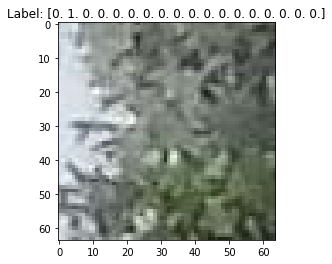

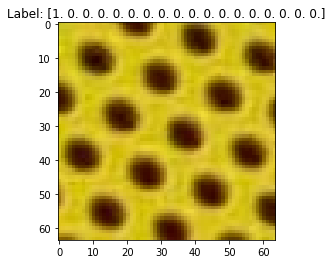

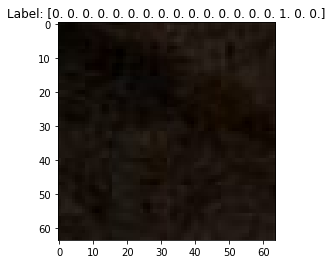

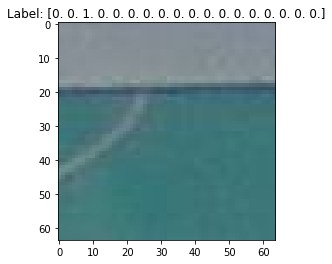

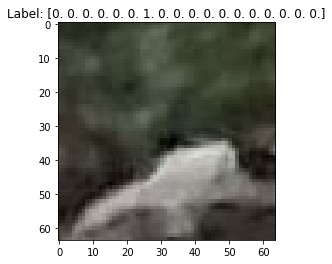

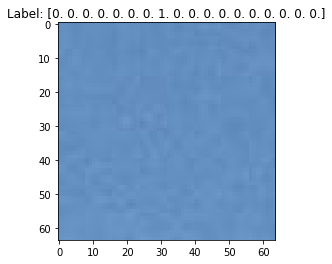

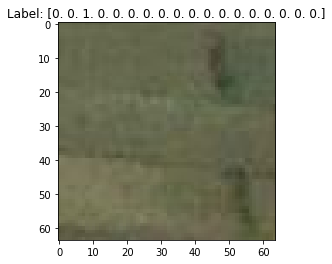

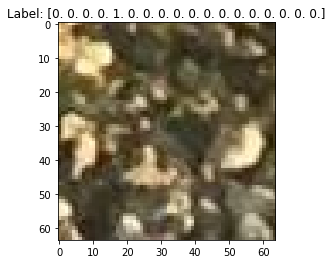

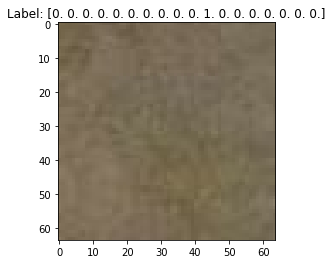

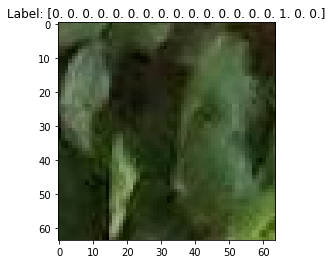

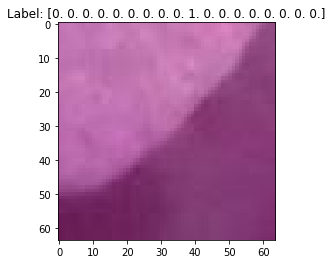

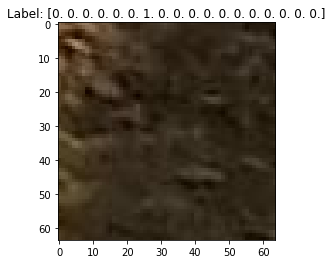

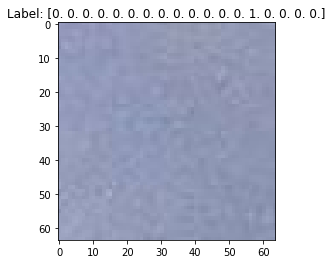

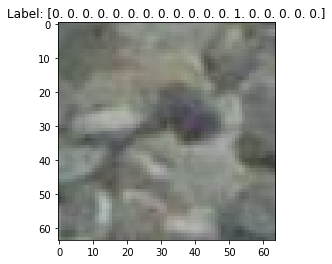

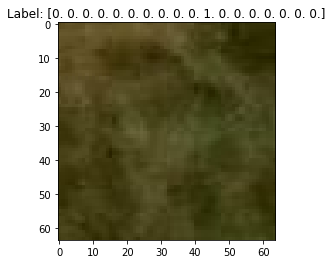

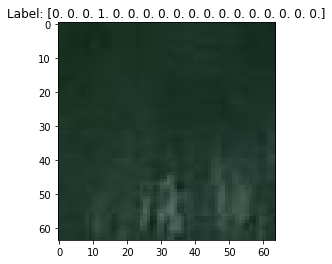

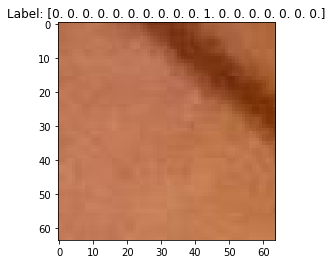

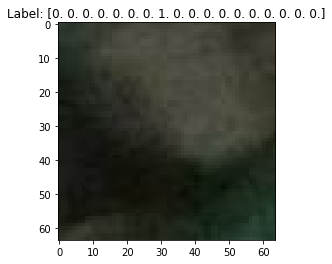

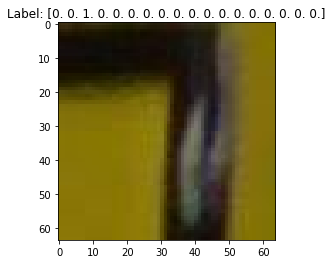

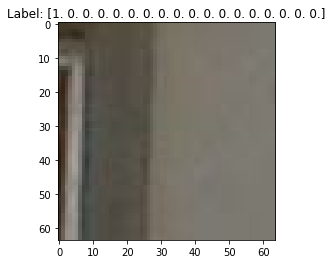

In [176]:
def plot_data_samples(dataset, nr_plots=20):
    # get first batch of dataset for plotting
    for idx, (image, label) in enumerate(dataset):
        plt.imshow(image/255.0)  # normalize just for matplotlib (as floats need to be in range [0, 1])
        plt.title('Label: {}'.format(label))
        plt.show()

        if idx==nr_plots-1:
            break

# print samples
plot_data_samples(train_data)

As a preprocessing step, calculate the pixelwise average of the entire training set and do a standardization of the entire data (subtrcting pixelwise average and scaling intensity amplitude to reduce the image dynamics).

In [177]:
### get average image as substrct that later from each sample (and do amplitude scaling)

def get_pixelwise_average(train_dataset):
    average_image = tf.zeros((64, 64, 3), tf.int64)
    total_images = 0

    for idx, (images, labels) in enumerate(tqdm(train_dataset, total=len(train_dataset))):
        # reduce sum along batch dimension to sum up all pixel intensities
        average_image = tf.add(average_image, tf.reduce_sum(tf.cast(images, tf.int64), 0))

        total_images += images.shape[0]  # add number of images of each batch

    return average_image, total_images

average_image, total_images = get_pixelwise_average(train_data)

  0%|          | 0/97098 [00:00<?, ?it/s]

In [178]:
#### average_image, total_images = get_pixelwise_average(train_dataset)

normalizing_image = tf.divide(average_image, total_images)
# print(normalizing_image)
####
# save average image to save computation time
numpy_norm_image = normalizing_image.numpy()
np.save('/Users/Ascanio/Desktop/PROG_VISIOPE/norm_imag.npy', numpy_norm_image)
print('Saved successfully.')

Saved successfully.


In [179]:
numpy_norm_image_loaded = np.load('/Users/Ascanio/Desktop/PROG_VISIOPE/norm_imag.npy')
print(numpy_norm_image_loaded)

print(np.amax(numpy_norm_image_loaded))

[[[82.24216336 84.25213782 75.92969378]
  [82.08261853 84.20939363 75.72404587]
  [82.14200119 84.16332339 75.81162041]
  ...
  [81.78779332 83.69600462 75.32105225]
  [81.90971235 83.71758896 75.47003816]
  [81.88219923 83.805663   75.4189012 ]]

 [[82.24216336 84.25213782 75.92969378]
  [82.08261853 84.20939363 75.72404587]
  [82.14200119 84.16332339 75.81162041]
  ...
  [81.78779332 83.69600462 75.32105225]
  [81.90971235 83.71758896 75.47003816]
  [81.88219923 83.805663   75.4189012 ]]

 [[82.24216336 84.25213782 75.92969378]
  [82.08261853 84.20939363 75.72404587]
  [82.14200119 84.16332339 75.81162041]
  ...
  [81.78779332 83.69600462 75.32105225]
  [81.90971235 83.71758896 75.47003816]
  [81.88219923 83.805663   75.4189012 ]]

 ...

 [[82.24216336 84.25213782 75.92969378]
  [82.08261853 84.20939363 75.72404587]
  [82.14200119 84.16332339 75.81162041]
  ...
  [81.78779332 83.69600462 75.32105225]
  [81.90971235 83.71758896 75.47003816]
  [81.88219923 83.805663   75.4189012 ]]

 [

In [180]:
## subtract average_image from each picture, cut off negative values
def map_subtract_average_and_scale(image, label):
        # path and label represent a single sample

        image -= numpy_norm_image_loaded  # subtract average image
        image *= 0.0125  # scale amplitude

        return image, label

In [181]:
datasets = [train_data, val_data, test_data]
averaged_datasets = []

for dataset in datasets:
    averaged_dataset = dataset.map(map_subtract_average_and_scale, num_parallel_calls=8)
    averaged_datasets.append(averaged_dataset)

train_data, val_data, test_data = averaged_datasets

In [182]:
for image, label in train_data:
    print(image)
    print(tf.nn.relu(image))

    break

tf.Tensor(
[[[ 1.321973    1.4093484   1.600879  ]
  [ 1.5614673   1.6473826   1.8409494 ]
  [ 1.5232251   1.6104584   1.7773548 ]
  ...
  [-0.02234745  0.02879992  0.00848684]
  [ 0.15112858  0.20353012  0.18162452]
  [ 0.08897247  0.1399292   0.11976375]]

 [[ 1.409473    1.4968483   1.6883789 ]
  [ 1.5489672   1.6348826   1.8284495 ]
  [ 1.548225    1.6354584   1.8023548 ]
  ...
  [-0.23484746 -0.18370008 -0.20401315]
  [-0.06137142 -0.00896988 -0.03087549]
  [-0.16102754 -0.1100708  -0.13023625]]

 [[ 1.584473    1.6718483   1.8633789 ]
  [ 1.5864673   1.6723826   1.8659495 ]
  [ 1.5857251   1.6729584   1.8398548 ]
  ...
  [-0.18484746 -0.13370009 -0.15401316]
  [-0.16137142 -0.10896988 -0.1308755 ]
  [-0.31102753 -0.2600708  -0.28023624]]

 ...

 [[ 1.6344731   1.6718483   1.825879  ]
  [ 1.5364673   1.5723826   1.7284495 ]
  [ 1.423225    1.4604585   1.6148548 ]
  ...
  [-0.35984746 -0.28370008 -0.34151316]
  [-0.02387142  0.05353012 -0.00587549]
  [-0.02352753  0.0524292  -0.005

In [183]:
def get_uncompiled_model(nr_classes):
    inputs = tf.keras.Input(shape=(64, 64, 3), name="inputs")
    x = tf.keras.layers.Conv2D(32, (4, 4), input_shape=(64, 64, 3))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv2D(48, (5, 5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x=  tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    x = tf.keras.layers.Conv2D(64, (5, 5), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x =  tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    # keep in mind: due to odd dimension after convolution operations, we have shape (1, 4, 4, 64) after maxpool3 -> change last kernel size to (4, 4) instead, otherwise we'll get an empty tensor
    x = tf.keras.layers.Conv2D(64, (5, 5))(x) ######### originally it was 128
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(nr_classes)(x)  # remove activation='softmax', done at CategoricalCrossEntropy

    outputs = x

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [184]:
# use SGD with weight decay (=SGDW) and learning rate scheduling

class LRHalfing(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr):
        self.initial_lr = initial_lr

    @tf.function
    def __call__(self, step):
        if step > 0 and step%10==0:
            self.initial_lr /= 2

        return self.initial_lr

# optimizer = tfa.optimizers.SGDW(learning_rate=LRHalfing(0.015), weight_decay=7.5e-3, momentum=0.9)  # other lr: 0.015, weight_decay=7.5e-3, momentum=0.9, )
# optimizer = tf.optimizers.RMSprop(learning_rate=LRHalfing(0.01))
optimizer = tf.optimizers.SGD(learning_rate = LRHalfing(0.015))
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [185]:
### use keras implementation of fit to overcome problem of really slow dataset iterator
model = get_uncompiled_model(nr_classes=nr_classes)
model.summary()

model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.CategoricalAccuracy()])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 61, 61, 32)        1568      
_________________________________________________________________
batch_normalization_32 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 48)        38448     
_________________________________________________________________
batch_normalization_33 (Batc (None, 26, 26, 48)        192       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 13, 13, 48)        0   

In [186]:
# set checkpoint preferences

batch_size = 128
train_data_batched = train_data.shuffle(buffer_size=1024).batch(batch_size)
val_data_batched = val_data.batch(batch_size)

# set checkpoint preferences
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

checkpoint_filepath = '/Users/Ascanio/Desktop/PROG_VISIOPE/CNN_CamModel_checkpoint_V1/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

history = model.fit(train_data_batched, validation_data=val_data_batched, callbacks=[model_checkpoint_callback, early_stop], epochs=50, verbose=1)

Epoch 1/50
759/759 [==============================] - 39s 50ms/step - loss: 2.6753 - categorical_accuracy: 0.1403 - val_loss: 2.6486 - val_categorical_accuracy: 0.1524
Epoch 2/50
759/759 [==============================] - 38s 49ms/step - loss: 2.5745 - categorical_accuracy: 0.1740 - val_loss: 2.5690 - val_categorical_accuracy: 0.1796
Epoch 3/50
759/759 [==============================] - 38s 50ms/step - loss: 2.5059 - categorical_accuracy: 0.1950 - val_loss: 2.6149 - val_categorical_accuracy: 0.1743
Epoch 4/50
759/759 [==============================] - 38s 50ms/step - loss: 2.4531 - categorical_accuracy: 0.2101 - val_loss: 2.6782 - val_categorical_accuracy: 0.1711
Epoch 5/50
759/759 [==============================] - 38s 49ms/step - loss: 2.4072 - categorical_accuracy: 0.2252 - val_loss: 2.8928 - val_categorical_accuracy: 0.1475
Epoch 6/50
759/759 [==============================] - 38s 50ms/step - loss: 2.3686 - categorical_accuracy: 0.2376 - val_loss: 3.1320 - val_categorical_accuracy:

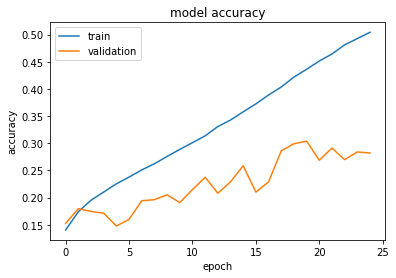

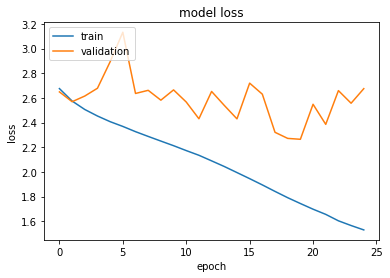

In [187]:
# accuracy plot
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [188]:
def plot_confusion_matrix(confusion_matrix, label_names=None, nr_classes=18):
    print(np.sum(confusion_matrix))

    if label_names is not None:
        df_cm = pd.DataFrame(confusion_matrix, index = [i for i in label_names],
                  columns = [i for i in range(nr_classes)])
    else:
        df_cm = pd.DataFrame(confusion_matrix, index = [i for i in range(nr_classes)],
                  columns = [i for i in range(nr_classes)])

    plt.figure(figsize = (20, 16))
    df_cm.fillna(value=np.nan, inplace=True)
    df_cm = df_cm[df_cm.columns].astype(float)
    sn.heatmap(df_cm, annot=True)

1.0
tf.Tensor(1.0, shape=(), dtype=float64)


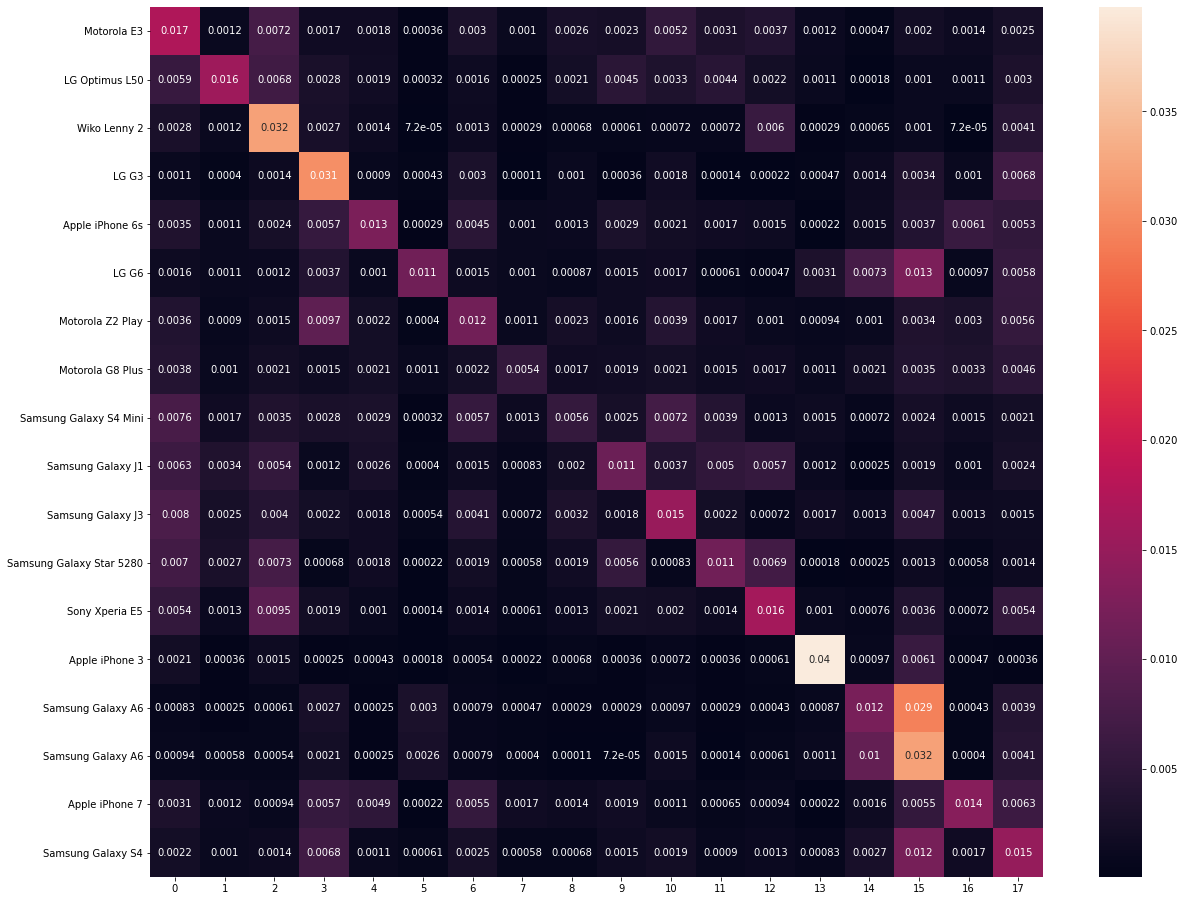

In [189]:
list_test_data = list(test_data)

test_labels = np.array([i[1] for i in list_test_data])
test_labels_index_format = np.array([tf.math.argmax(i) for i in test_labels])
test_labels_index_format

# train_data_batched = train_data.batch(batch_size)
# val_data_batched = val_data.batch(batch_size)
test_data_batched = test_data.batch(batch_size)

test_predictions = model.predict(test_data_batched)
test_index_format_predictions = np.array([tf.math.argmax(i) for i in test_predictions])
confusion_matrix = cm_func(test_labels_index_format, test_index_format_predictions)
confusion_matrix = confusion_matrix / tf.reduce_sum(confusion_matrix) 
plot_confusion_matrix(confusion_matrix, label_names)

print(tf.reduce_sum(confusion_matrix))

In [190]:
print(np.array(list_test_data).shape)
print(list_test_data[:2])

(27742, 2)
[(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[ 1.009473  ,  0.7718483 ,  0.78837883],
        [ 1.0864673 ,  0.8723826 ,  0.8909494 ],
        [ 0.59822506,  0.41045848,  0.4398547 ],
        ...,
        [-0.17234746, -0.49620008, -0.51651317],
        [-0.7113714 , -1.0339699 , -0.9433755 ],
        [ 0.31397247, -0.0100708 , -0.03023624]],

       [[ 1.146973  ,  0.9093483 ,  0.9258788 ],
        [ 1.2239673 ,  0.98488253,  1.0034494 ],
        [ 0.72322506,  0.5354585 ,  0.56485474],
        ...,
        [-0.02234745, -0.34620008, -0.36651316],
        [-0.57387143, -0.8964699 , -0.9183755 ],
        [ 0.25147247, -0.0725708 , -0.09273624]],

       [[ 1.271973  ,  1.0093483 ,  1.0258788 ],
        [ 1.2614673 ,  1.0223826 ,  1.0284494 ],
        [ 0.84822506,  0.63545847,  0.6523547 ],
        ...,
        [-0.05984745, -0.3837001 , -0.40401316],
        [-0.73637146, -1.0464699 , -0.9433755 ],
        [-0.19852753, -0.5225708 , -0.54273623]],

       

C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


##### SVM Training with this model

In [191]:
### load checkpoint test
model = get_uncompiled_model(nr_classes=nr_classes)
model.load_weights('/Users/Ascanio/Desktop/PROG_VISIOPE/CNN_CamModel_checkpoint_V1/')

# remove last dense layer (as we want the extracted feature vectors only)
evaluation_model = tf.keras.models.Sequential()
for layer in model.layers[:-1]:
    evaluation_model.add(layer)

evaluation_model.layers.pop()

evaluation_model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.CategoricalAccuracy()])
evaluation_model.summary()

model = evaluation_model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 61, 61, 32)        1568      
_________________________________________________________________
batch_normalization_36 (Batc (None, 61, 61, 32)        128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 26, 26, 48)        38448     
_________________________________________________________________
batch_normalization_37 (Batc (None, 26, 26, 48)        192       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 48)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 13, 13, 64)       

In [192]:
def prepare_SVM_data(CNN_model, dataset):
    '''Create feature vectors with trained CNN and save these as new dataset 
       with corresponding indexed label.'''

    feature_vectors = CNN_model.predict(dataset.batch(128))

    # convert label from one-hot encoding back to index as neede for SVM training
    labels = np.array([tf.argmax(one_hot_label, axis=0) for image, one_hot_label in dataset])

    return feature_vectors, labels

In [193]:
train_x, train_y = prepare_SVM_data(model, train_data)
val_x, val_y = prepare_SVM_data(model, val_data)
test_x, test_y = prepare_SVM_data(model, test_data)

In [194]:
# have to flatten train_x for SVM right?

print(train_x.shape)


# print(train_x.shape, train_y.shape)
# print(val_x.shape, val_y.shape)
# print(test_x.shape, .shape)

(97098, 128)


In [195]:
### save data as passing through CNN model takes really lots of time
saving_path = '/Users/Ascanio/Desktop/PROG_VISIOPE/SVMdata_full_orig/'
np.savetxt(os.path.join(saving_path, 'train_x'), train_x)
np.savetxt(os.path.join(saving_path, 'train_y'), train_y)
np.savetxt(os.path.join(saving_path, 'val_x'), val_x)
np.savetxt(os.path.join(saving_path, 'val_y'), val_y)
np.savetxt(os.path.join(saving_path, 'test_x'), test_x)
np.savetxt(os.path.join(saving_path, 'test_y'), test_y)

In [196]:
# We do not have the compute to make it converge
# This cell already took a large number of hours to execute
# so we could not raise the max_iter parameter

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

# training the SVM in one-to-one fashion
SVMClassifier = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=100000, C=1.0)).fit(train_x, train_y)

# do prediction
predictions = tf.convert_to_tensor(SVMClassifier.predict(test_x))

list_test_data = list(test_data)
normalization = len(test_data)
normalization

# We do not have the computational power to make it converge
# This cell already took a large number of hours to execute so we could not raise the max_iter parameter

C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed

27742

In [197]:
np.savetxt(os.path.join(saving_path, 'test_x'), test_x)
np.savetxt(os.path.join(saving_path, 'test_y'), test_y)
np.savetxt(os.path.join(saving_path, 'predictions'), predictions)

In [198]:
print(tf.reduce_sum(confusion_matrix))

print('labels:')
print(test_y)
print('Predictions:')
print(predictions)

print('\nLabel shape: {}'.format(test_y.shape))
print('Predictions shape: {}'.format(predictions.shape))

tf.Tensor(1.0, shape=(), dtype=float64)
labels:
[ 0  0 16 ...  1 15  4]
Predictions:
tf.Tensor([12 12 15 ...  1 14  4], shape=(27742,), dtype=int64)

Label shape: (27742,)
Predictions shape: (27742,)


27742.0


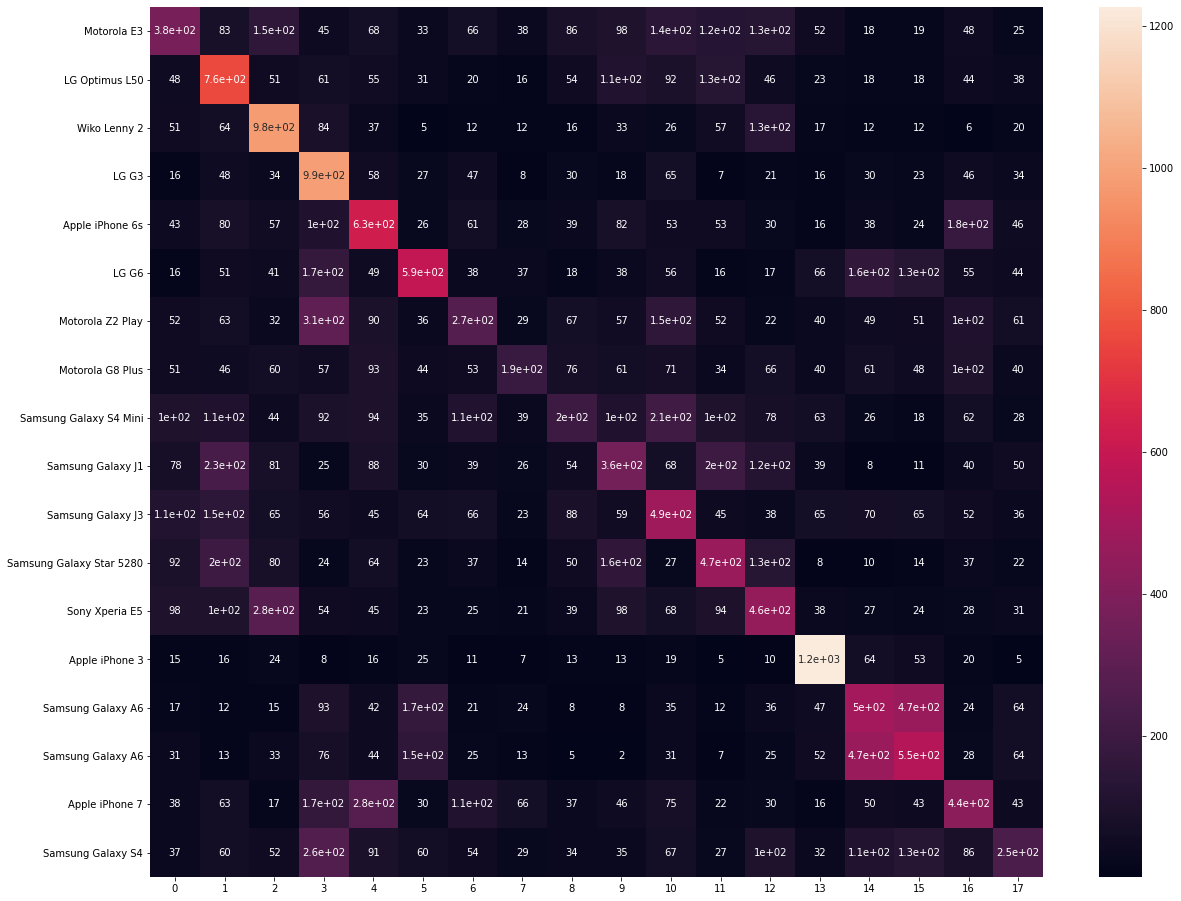

In [199]:
import sklearn
import pandas as pd
import seaborn as sn

SVMClassifier.score(test_x, test_y, sample_weight=None)
confusion_matrix = sklearn.metrics.confusion_matrix(test_y, predictions)/np.sum(confusion_matrix)
plot_confusion_matrix(confusion_matrix, label_names) ################### , label_names

In [200]:
print(max(test_y))
print(test_y)

17
[ 0  0 16 ...  1 15  4]


In [201]:
from sklearn.metrics import accuracy_score
      
pred = SVMClassifier.predict(test_x)

print("accuracy:", accuracy_score(test_y, pred)*100)


accuracy: 35.06956960565208


In [202]:
'''
### cross validation
from sklearn.model_selection import KFold, cross_val_score
n_splits = 5
k_fold = KFold(n_splits=n_splits)

print(type(train_x), type(train_y))

cross_val_scores = cross_val_score(SVMClassifier, train_x, train_y, cv=k_fold, n_jobs=-1)

averaged_acc = sum(cross_val_scores)/len(cross_val_scores)
print('Accuracy after {}-fold cross validation: {}'.format(n_splits, averaged_acc))
'''

"\n### cross validation\nfrom sklearn.model_selection import KFold, cross_val_score\nn_splits = 5\nk_fold = KFold(n_splits=n_splits)\n\nprint(type(train_x), type(train_y))\n\ncross_val_scores = cross_val_score(SVMClassifier, train_x, train_y, cv=k_fold, n_jobs=-1)\n\naveraged_acc = sum(cross_val_scores)/len(cross_val_scores)\nprint('Accuracy after {}-fold cross validation: {}'.format(n_splits, averaged_acc))\n"

### SVM one vs one

In [203]:
# We do not have the compute to make it converge
# This cell already took a large number of hours to execute
# so we could not raise the max_iter parameter

SVMClassifier2 = OneVsOneClassifier(LinearSVC(random_state=0, max_iter=100000, C=1.0)).fit(train_x, train_y)

# do prediction
predictions = tf.convert_to_tensor(SVMClassifier2.predict(test_x))

list_test_data = list(test_data)
normalization = len(test_data)
normalization

# We do not have the computational power to make it converge
# This cell already took a large number of hours to execute so we could not raise the max_iter parameter

C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Ascanio\Anaconda3\envs\gputest\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed

27742

In [204]:
np.savetxt(os.path.join(saving_path, 'test_x'), test_x)
np.savetxt(os.path.join(saving_path, 'test_y'), test_y)
np.savetxt(os.path.join(saving_path, 'predictions'), predictions)

In [205]:
print(tf.reduce_sum(confusion_matrix))

print('labels:')
print(test_y)
print('Predictions:')
print(predictions)

print('\nLabel shape: {}'.format(test_y.shape))
print('Predictions shape: {}'.format(predictions.shape))

tf.Tensor(27742.0, shape=(), dtype=float64)
labels:
[ 0  0 16 ...  1 15  4]
Predictions:
tf.Tensor([12 12 17 ...  1 14  4], shape=(27742,), dtype=int64)

Label shape: (27742,)
Predictions shape: (27742,)


In [206]:
print(max(test_y))

17


1.0
17


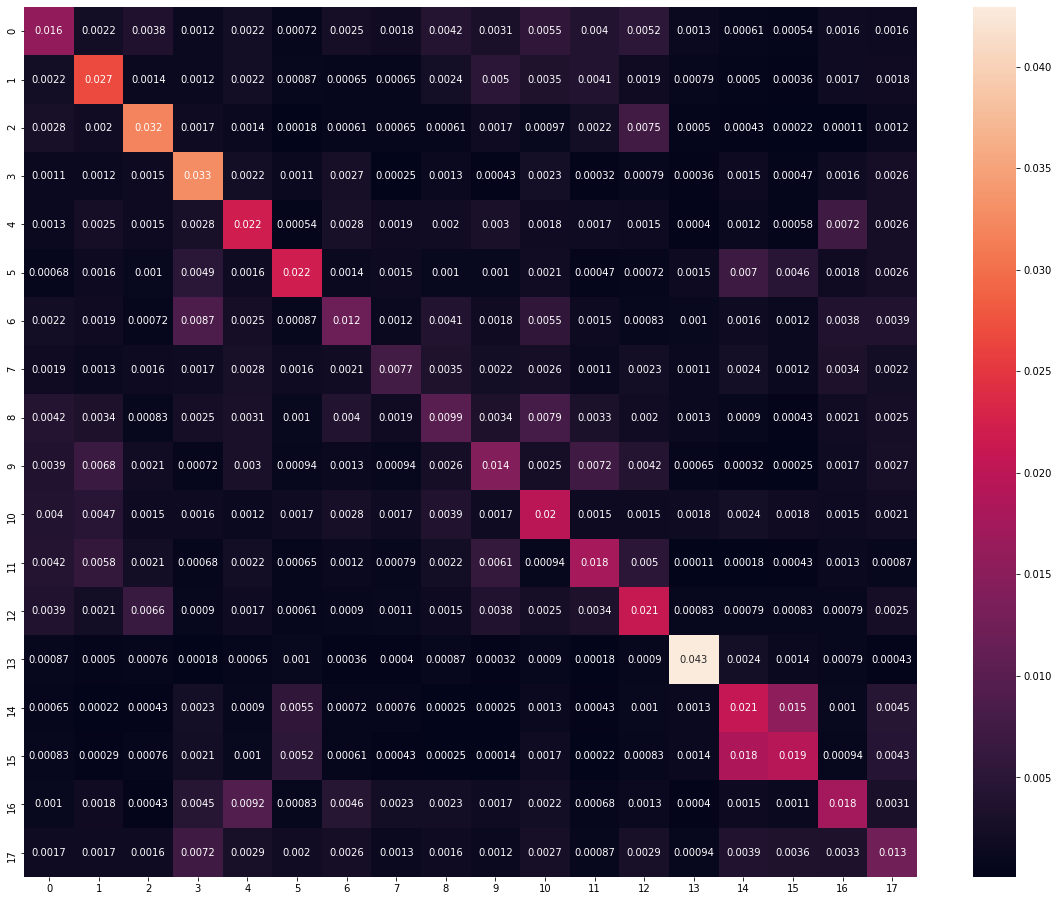

In [207]:
import sklearn
import pandas as pd
import seaborn as sn

SVMClassifier2.score(test_x, test_y, sample_weight=None)
confusion_matrix = sklearn.metrics.confusion_matrix(test_y, predictions)/np.sum(confusion_matrix)
plot_confusion_matrix(confusion_matrix) ################### , label_names
print(max(test_y))

In [209]:
from sklearn.metrics import accuracy_score
      
pred = SVMClassifier2.predict(test_x)

print("accuracy: ", accuracy_score(test_y, pred)*100)


accuracy:  36.677240285487706


### Efficient Net

In [80]:
class LRHalfing(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr):
        self.initial_lr = initial_lr

    @tf.function
    def __call__(self, step):
        if step > 0 and step%10==0:
            self.initial_lr /= 2

        return self.initial_lr

In [81]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# create the base pre-trained model
# --------  IMAGE MUST GO FROM 0 to 255 --------
# RELOADING because the dataset loaded before was normalized
dataset_sample_factor = 0.7

print('Train data samples: ')
train_data = DataLoader.train_dataset
train_data = train_data.take(int(len(train_data)*dataset_sample_factor))
print(len(train_data))

print('\nValidation data samples: ')
val_data = DataLoader.val_dataset
val_data = val_data.take(int(len(val_data)*dataset_sample_factor))
print(len(val_data))

print('\nTest data samples: ')
test_data = DataLoader.test_dataset
test_data = test_data.take(int(len(test_data)*dataset_sample_factor))
print(len(test_data))


base_model = EfficientNetB1(weights='imagenet', include_top=False)

print("Check that this goes from 0 to 255")
print(train_data)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.05, noise_shape=None, seed=None)(x)

# and a logistic layer -- let's say we have 17 classes
NUMBER_OF_CLASSES = 18
predictions = Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True # False

    
optimizer = tf.keras.optimizers.Adam(
    learning_rate= LRHalfing(0.0001), beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
# only trains the new dense layers

# BE CAREFUL OF INPUT RANGE
# EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range.
# so we should avoid normalizing the data!
batch_size = 128



train_data_batched = train_data.batch(batch_size)
val_data_batched = val_data.batch(batch_size)
test_data_batched = test_data.batch(batch_size)

# set checkpoint preferences
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=4, min_lr=0.0001)
# print(model.summary())

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True)

history = model.fit(train_data_batched, validation_data=val_data_batched, epochs=50, verbose=1, callbacks=[early_stop])

Train data samples: 
97098

Validation data samples: 
13871

Test data samples: 
27742
Check that this goes from 0 to 255
<TakeDataset shapes: ((None, None, 3), (18,)), types: (tf.float32, tf.float32)>
Epoch 1/50
759/759 [==============================] - 210s 260ms/step - loss: 2.4649 - accuracy: 0.2226 - val_loss: 1.8632 - val_accuracy: 0.3946
Epoch 2/50
759/759 [==============================] - 184s 242ms/step - loss: 1.6343 - accuracy: 0.4606 - val_loss: 1.3622 - val_accuracy: 0.5427
Epoch 3/50
759/759 [==============================] - 184s 242ms/step - loss: 1.2092 - accuracy: 0.5934 - val_loss: 1.1416 - val_accuracy: 0.6152
Epoch 4/50
759/759 [==============================] - 183s 242ms/step - loss: 0.9344 - accuracy: 0.6820 - val_loss: 1.0517 - val_accuracy: 0.6484
Epoch 5/50
759/759 [==============================] - 184s 242ms/step - loss: 0.7321 - accuracy: 0.7508 - val_loss: 1.0090 - val_accuracy: 0.6700
Epoch 6/50
759/759 [==============================] - 184s 243ms/ste

In [82]:
# let's double check that the best model has been saved
model.evaluate(val_data_batched)

109/109 [==============================] - 8s 77ms/step - loss: 1.2633 - accuracy: 0.7127


[1.263253092765808, 0.7127099633216858]

In [83]:
preds = model.predict(test_data_batched)

In [84]:
preds

array([[2.6398098e-01, 2.1003748e-07, 4.2267629e-09, ..., 1.3960263e-08,
        2.3084410e-09, 4.4472435e-09],
       [1.9960994e-06, 9.7554432e-05, 1.2777703e-08, ..., 3.1111179e-07,
        2.2189897e-02, 1.4015267e-06],
       [8.1014741e-07, 8.8036368e-06, 5.9596850e-08, ..., 2.0261259e-05,
        1.9669685e-06, 8.8550568e-01],
       ...,
       [3.3690268e-04, 6.0727297e-07, 1.6382281e-05, ..., 4.3449106e-04,
        2.2657739e-06, 8.3454198e-01],
       [7.5543021e-08, 2.1236782e-10, 1.1815224e-10, ..., 5.9698046e-08,
        1.2443884e-09, 3.0819347e-06],
       [2.9705800e-04, 2.6765208e-06, 7.4439924e-07, ..., 1.4173846e-05,
        1.2301492e-05, 5.0039007e-06]], dtype=float32)

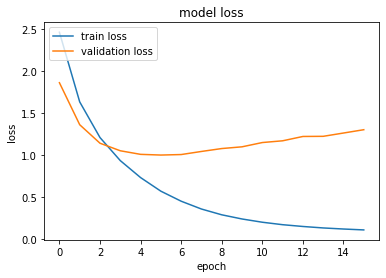

In [85]:
# loss plot 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.show()

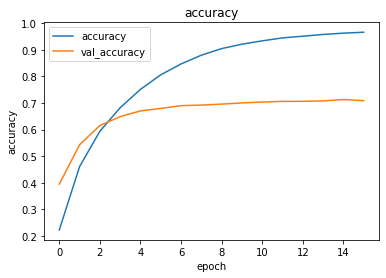

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [87]:
list_test_data = list(test_data)
normalization = len(test_data)
normalization

27742

In [88]:
test_labels = np.array([i[1] for i in list_test_data])
test_labels_index_format = np.array([tf.math.argmax(i) for i in test_labels])
test_labels_index_format

array([ 8, 10,  9, ..., 17, 10, 10], dtype=int64)

In [89]:
print()

1.0


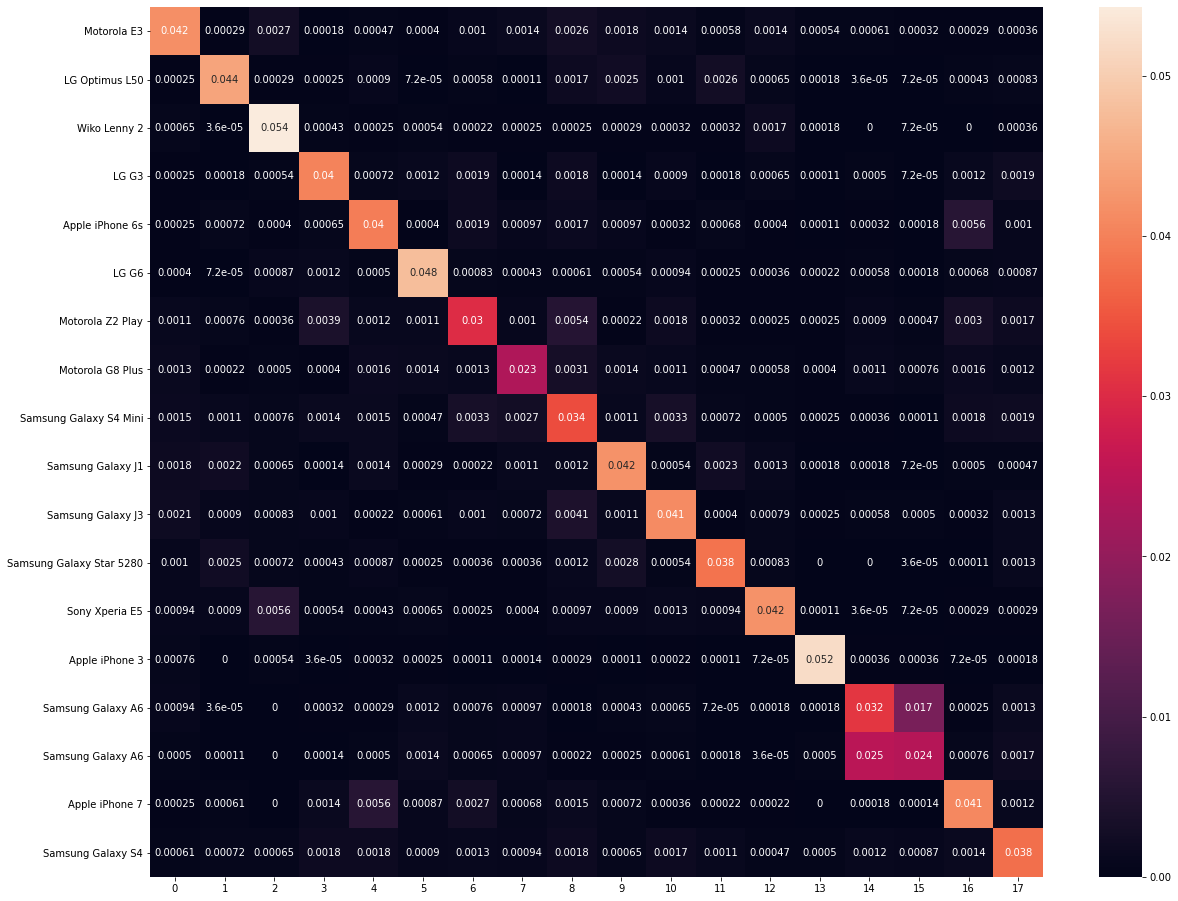

In [90]:
from sklearn.metrics import confusion_matrix as cm_func
import pandas as pd
import seaborn as sn


def plot_confusion_matrix(confusion_matrix, label_names=None, nr_classes=18):
    print(np.sum(confusion_matrix))

    if label_names is not None:
        df_cm = pd.DataFrame(confusion_matrix, index = [i for i in label_names],
                  columns = [i for i in range(nr_classes)])
    else:
        df_cm = pd.DataFrame(confusion_matrix, index = [i for i in range(nr_classes)],
                  columns = [i for i in range(nr_classes)])

    plt.figure(figsize = (20, 16))
    # df_cm.fillna(value=np.nan, inplace=True)
    df_cm = df_cm[df_cm.columns].astype(float)
    sn.heatmap(df_cm, annot=True)

# print(len(label_names))
test_predictions = model.predict(test_data_batched)
test_index_format_predictions = np.array([tf.math.argmax(i) for i in test_predictions])
confusion_matrix = cm_func(test_labels_index_format, test_index_format_predictions) / normalization
plot_confusion_matrix(confusion_matrix, label_names)

In [91]:
# check that the normalization of the confusion matrix  is correct
tf.reduce_sum(confusion_matrix)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9999999999999999>